In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set()

In [2]:
import geopy.distance

In [3]:
import re

In [4]:
import sqlite3
import pandas as pd

In [5]:
from bokeh.plotting import figure, output_file, show
from bokeh.tile_providers import CARTODBPOSITRON, get_provider
from bokeh.models import ColumnDataSource
from pyproj import Proj, transform

# Pick an easy river

For starters I'm going to look at a single river at a time, and I'll start with an easy one. I expect a river will be easy to predict if:
 - it has a small catchment area. So the nearest rainfall station is pretty much represntative of all the rain that falls in the catchment
 - it has a small volume. So the river level will go up and down quickly in response to rainfall. 

Unfortunatly I don't (currently) have data about catchment size, and river volume, but I can take a guess  based off my own background knnowledge of the region. I would guess that maybe the Kangaroo river would be a good example for this, but lets have a look at its properties to check.

In [6]:
con = sqlite3.connect('./Data/mydb.db')
df_stations = pd.read_sql('SELECT * FROM Stations', con)
df_gauges = pd.read_sql('SELECT * FROM Gauges', con)
df_rainfall = pd.read_sql('SELECT * FROM Rainfall', con, index_col=['station_id', 'date'])
df_levels = pd.read_sql('SELECT * FROM Levels', con, index_col=['gauge_id', 'date'])

Allen river (barrington tops), Williams river (barrington tops), Bielsdown

In [7]:
df_gauges[df_gauges['name'].str.contains('Kangaroo')]

,id,name,lat,long,elev,NearestStat


In [8]:
df_gauges[df_gauges.id==215220]

,id,name,lat,long,elev,NearestStat


## Fetch raw data - hourly

hmmm, I seem to be missing data for the kangaroo river... I wonder why. For now I'll manually fetch the csv (from https://realtimedata.waternsw.com.au/) and I'll look into this problem later. 

In [9]:
df_levels = pd.read_csv('./Data/riverlevels/215220.csv')
df_levels = df_levels[['Time', '215220', 'Unnamed: 6']]
df_levels.columns = ['datetime', 'level', 'quality']
df_levels = df_levels.iloc[3:]
df_levels = df_levels.dropna()
df_levels['datetime'] = pd.to_datetime(df_levels['datetime'])
df_levels = df_levels.set_index('datetime')
df_levels['level'] = pd.to_numeric(df_levels['level'])

/home/jemma/anaconda3/envs/river_levels/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (1,2,3,4,5,6) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


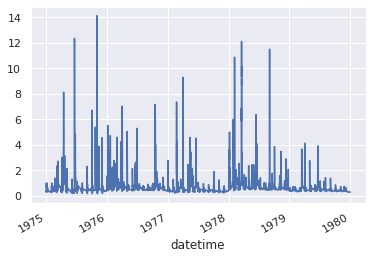

In [10]:
df_levels.loc['1975-01-01':'1980-01-01', 'level'].plot()

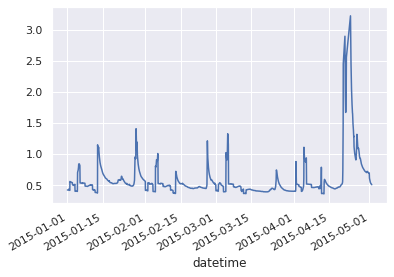

In [11]:
df_levels.loc['2015-01-01':'2015-05-01', 'level'].plot()

The kangaroo goes up and down a loooot! Much more than I would expect other rivers. Maybe the interesting points of this are around rainfall events, rather than around rising above minimum. 

## Rainfall

We have a lot of rainfall to stations to choose from. We want one which will tell us how much water is going into the kangaroo river. Lets see how well we can do by just looking at the nearest rainfall station.

Get the lat lon of the gauge at kangaroo. It's in the metadata in the river levels file which is culled on clean up. 

In [12]:
metadata = pd.read_csv('./Data/riverlevels/215220.csv', low_memory=False)['Unnamed: 7'][4]
display(metadata)

lat_lon_regex = '.* Lat:(?P<lat>[0-9\.-]*) Long:(?P<lon>[0-9\.-]*) .*'
lat_lon_regex_result = re.search(lat_lon_regex, metadata)
lat = float(lat_lon_regex_result.group('lat'))
lon = float(lat_lon_regex_result.group('lon'))
lat, lon

'215220 - KANGAROO RIVER AT HAMPDEN BRIDGE Lat:-34.72798991 Long:150.52244073 Elev:70m'

(-34.72798991, 150.52244073)

For each rainfall station, calculate its distance from our gauge. Pick the nearest.

In [13]:
df_stations['d_kang'] = df_stations.apply(lambda x: geopy.distance.geodesic((lat, lon), (x.lat, x.long)).km, axis=1)
nearest_station_id = df_stations.sort_values('d_kang').iloc[0].id
df_stations[df_stations.id == nearest_station_id]

,id,name,opened_year,closed,lat,long,elev,state,d_kang
361,68136,BOMADERRY,1903,None,-34.85,150.62,8,NSW,16.215134


Now lets have a quick look at the how well the rainfall seems to match up with the river levels. We would expect to see every spike in river levels associated with a spike in rainfall. 

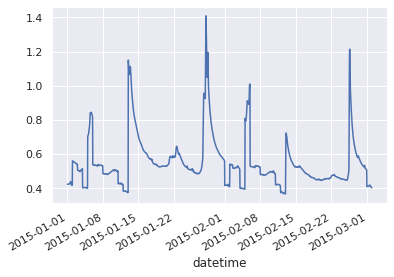

In [14]:
date_range = ('2015-01-01', '2015-03-01')
df_levels.loc[date_range[0]:date_range[1], 'level'].plot()

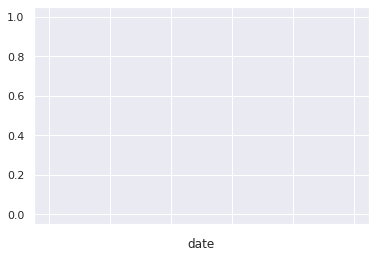

In [15]:
rainfall_kang = df_rainfall.loc[nearest_station_id]
rainfall_kang.loc[date_range[0]:date_range[1], 'rainfall'].plot()

Oh dear... this rainfall station has no data for this date range. That isn't going to be very useful. How about we try the next closest rainfall station. 

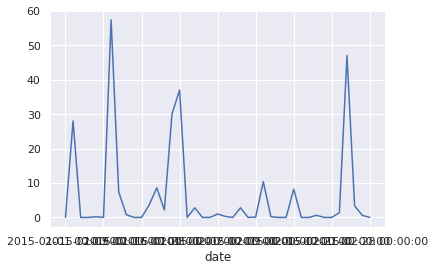

In [16]:
next_nearest_station_id = df_stations.sort_values('d_kang').iloc[1].id
rainfall_kang = df_rainfall.loc[next_nearest_station_id]
rainfall_kang.loc[date_range[0]:date_range[1], 'rainfall'].plot()

This seems pretty good... Where is it though?

## Find a good gauge

Where are all our stations? Lets plot the nearby rainfall stations on a map to see what our cmhoices are...

In [17]:
def lon_lat_to_wm(lon, lat):
    wm_x, wm_y = transform(Proj(init='epsg:4326'), Proj(init='epsg:3857'), lon, lat)  # longitude first, latitude second.
    return wm_x, wm_y

In [18]:
nearby_stations = df_stations[df_stations['d_kang']<20]
nearby_stations['wm_x'] = nearby_stations.apply(lambda x: lon_lat_to_wm(x.long, x.lat)[0], axis=1)
nearby_stations['wm_y'] = nearby_stations.apply(lambda x: lon_lat_to_wm(x.long, x.lat)[1], axis=1)
nearby_stations

/home/jemma/anaconda3/envs/river_levels/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/jemma/anaconda3/envs/river_levels/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,id,name,opened_year,closed,lat,long,elev,state,d_kang,wm_x,wm_y
355,68003,BERRY MASONIC VILLAGE,1886,None,-34.78,150.69,10,NSW,16.390906,1.677473e+07,-4.134024e+06
356,68031,BURRUER (ILLAROO),1902,None,-34.87,150.45,-9999,NSW,17.092062,1.674802e+07,-4.146229e+06
361,68136,BOMADERRY,1903,None,-34.85,150.62,8,NSW,16.215134,1.676694e+07,-4.143515e+06
364,68168,KNIGHTS HILL (CHANNEL 5A),1964,None,-34.62,150.69,765,NSW,19.476677,1.677473e+07,-4.112360e+06


In [19]:
output_file("tile.html")
tile_provider = get_provider(CARTODBPOSITRON)

# define our points in web mercator
wm_x, wm_y = lon_lat_to_wm(lon, lat)
rainfall_station_location = ColumnDataSource(nearby_stations)

# define the hover information
tooltips = [
    ('Name', '@name'),
    ('Distance from gauge', '@d_kang')
]

# range bounds supplied in web mercator coordinates
plot_size = 100000
x_range = (wm_x-plot_size/2, wm_x+plot_size/2)
y_range = (wm_y-plot_size/2, wm_y+plot_size/2)

# make the plot
p = figure(x_range=x_range, y_range=y_range, x_axis_type="mercator", y_axis_type="mercator", tooltips=tooltips)
p.add_tile(tile_provider)
p.circle(x=[wm_x], y=[wm_y], size=10, fill_color="red")
p.circle(x="wm_x", y="wm_y", size=15, fill_color="blue", fill_alpha=0.8, source=rainfall_station_location)

show(p)

OK, so none of the stations are particularly close, and none are on the plateu. So now we're choosing betweeen bad options. 

## Choose station based off correlation

To choose between the nearby stations, lets look at how well the rainfall levels correlate with the river level. I expect that the relationship will between rainfall and river level will be highly non-linear and incorporate some time delay. So to simplify this correlation, lets just look at how well 'its rained in the last 3 days' correlates with 'river is now above its median height'. So we don't care about the exact relationship between how much the river goes up with different amounts of rainfall (that will be a job for the actual model), what we're looking at here is whether this rainfall gauge is indicative of rainfall in the river's catchment. 

For starters, lets simplify the river level data. We want to extract whether or not the river was above its median on each day.

In [34]:
median_level = df_levels.level.median()

How often is the river above median? This approach is based off the assumption that its relatively rare. 

In [32]:
df_levels_max_daily = df_levels.groupby(df_levels.index.date).max()

In [43]:
n_days = len(df_levels_max_daily)
n_days_above_median = len(df_levels_max_daily[df_levels_max_daily['level']>median_level])
n_days_above_median / n_days

0.5270139309509388

And how often does it rain?

In [49]:
rainfall_at_nearest = df_rainfall.loc[nearest_station_id]
n_days = len(rainfall_at_nearest)
n_rainy_days = len(rainfall_at_nearest[rainfall_at_nearest.rainfall>0])
n_rainy_days/n_days

0.27114177195566236